In [40]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [41]:
datadir = 'data'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [42]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [46]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [8]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [9]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [10]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [11]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [12]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [13]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred)

In [14]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred)

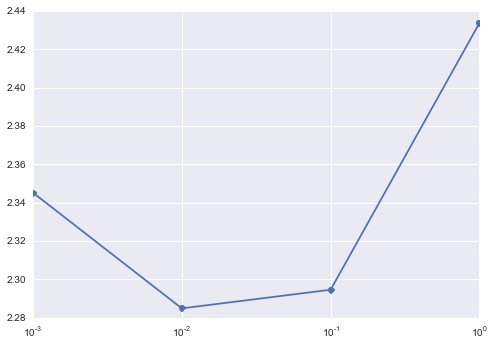

In [15]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [16]:
score(LogisticRegression(C=0.02))

2.2797069814301905

In [18]:
clf = LogisticRegression(C=0.02,  multi_class='multinomial',solver='lbfgs')
score(clf)

2.2733265743601407

In [60]:
clf = LogisticRegression(C=0.02, max_iter=24,  multi_class='multinomial',solver='lbfgs')
score(clf)

2.280562724171562

In [71]:
res = {}
Cs = [50, 100, 200, 500]
lr = [0.01, 0.1, 0.5, 1, 2]
for C in Cs:
    for l in lr:
        res[(C, l)] = score(AdaBoostClassifier(n_estimators = C, learning_rate=l))
#plt.semilogx(Cs, res,'-o');

In [62]:
from sklearn.ensemble import AdaBoostClassifier
rf = AdaBoostClassifier()
#rf.fit(Xtrain, y)
score(rf)

2.4769610016626129

In [58]:
RandomForestClassifier?

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=100),
                             max_samples=0.5, max_features=0.5, n_estimators=10, oob_score=True)

In [39]:
bagging.fit(Xtrain, y)

<74645x21527 sparse matrix of type '<class 'numpy.float64'>'
	with 2707712 stored elements in Compressed Sparse Row format>

In [29]:
pred2 = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)


In [35]:
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001513,0.006101,0.013637,0.013259,0.025975,0.045777,0.011867,0.033667,0.073409,0.119829,0.255571,0.399396
-1547860181818787117,0.007528,0.013073,0.029436,0.058526,0.071005,0.153002,0.005915,0.088306,0.053270,0.075139,0.229308,0.215493
7374582448058474277,0.022390,0.036535,0.036035,0.160910,0.163751,0.081077,0.013268,0.026466,0.043694,0.103199,0.181252,0.131423
-6220210354783429585,0.003732,0.030554,0.008868,0.012727,0.050348,0.176924,0.047741,0.138518,0.069532,0.092738,0.178918,0.189399
-5893464122623104785,0.047382,0.065103,0.042691,0.062503,0.056653,0.043352,0.092242,0.164738,0.097403,0.101849,0.132844,0.093238


In [33]:
pred2.to_csv('results.csv',index=True)